In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
acceleration = pd.read_csv("acceleration.csv")

In [3]:
acceleration

,Time (s),Linear Acceleration x (m/s^2),Linear Acceleration y (m/s^2),Linear Acceleration z (m/s^2),Absolute acceleration (m/s^2)
0,0.000000,0.000000,0.000000,-0.000000,0.000000
1,0.004974,-0.018037,0.028188,-0.211176,0.213811
2,0.009888,0.014396,-0.010963,-0.157506,0.158542
3,0.014832,-0.013366,-0.027011,0.205908,0.208102
4,0.019775,-0.056252,-0.061009,0.474857,0.482054
...,...,...,...,...,...
75613,374.711282,-0.308648,-0.053848,1.238031,1.277061
75614,374.716256,-0.217882,-0.110128,0.963994,0.994427
75615,374.721200,-0.014150,-0.105279,0.499515,0.510685
75616,374.726144,0.233272,-0.151984,0.244950,0.370831


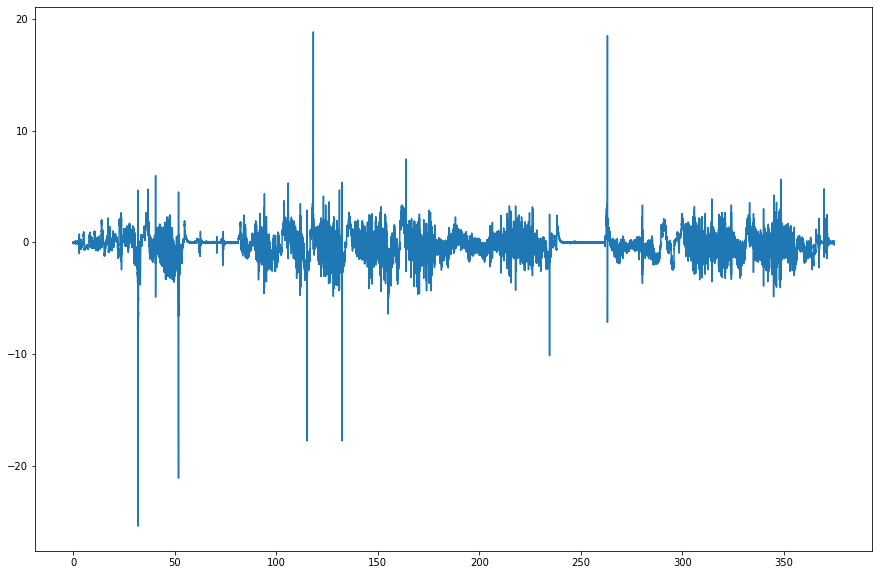

In [7]:
plt.figure(figsize=(15, 10))
plt.plot(acceleration["Time (s)"], acceleration["Linear Acceleration y (m/s^2)"], )

In [5]:
vehicle = pd.read_csv("vehicle-translated.csv")
vehicle_start_time = datetime.datetime.fromisoformat(vehicle["Time [s]"][0]).timestamp()
vehicle_times = [
    datetime.datetime.fromisoformat(vt).timestamp()-vehicle_start_time
    for vt in vehicle["Time [s]"]]
vehicle

,Time [s],Computed Engine Load,Engine RPM,Speed,Air throughput (MAF Sensor),Absolute Engine Load,Relative throttle position,Relative gas pedal position,Unnamed: 8
0,2019-10-31 21:04:01.095,15.686275,902.25,0.0,4.41,17.647058,1.960784,0.0,NaN
1,2019-10-31 21:04:07.470,15.686275,902.25,0.0,4.41,17.647058,1.960784,0.0,NaN
2,2019-10-31 21:04:18.196,16.470589,887.75,0.0,3.97,16.862745,1.568627,0.0,NaN
3,2019-10-31 21:04:24.471,16.470589,887.75,0.0,3.97,17.647058,1.960784,0.0,NaN
4,2019-10-31 21:04:35.114,19.215687,739.00,0.0,5.06,17.254902,1.568627,0.0,NaN
...,...,...,...,...,...,...,...,...,...
402,2019-10-31 21:14:44.470,16.078432,691.25,0.0,3.20,16.862745,1.176471,0.0,NaN
403,2019-10-31 21:14:46.896,16.470589,712.50,0.0,2.79,16.470589,1.176471,0.0,NaN
404,2019-10-31 21:14:49.321,19.607843,710.50,0.0,2.58,16.862745,1.176471,0.0,NaN
405,2019-10-31 21:14:51.720,20.000000,705.75,0.0,3.20,16.470589,1.176471,0.0,NaN


No handles with labels found to put in legend.


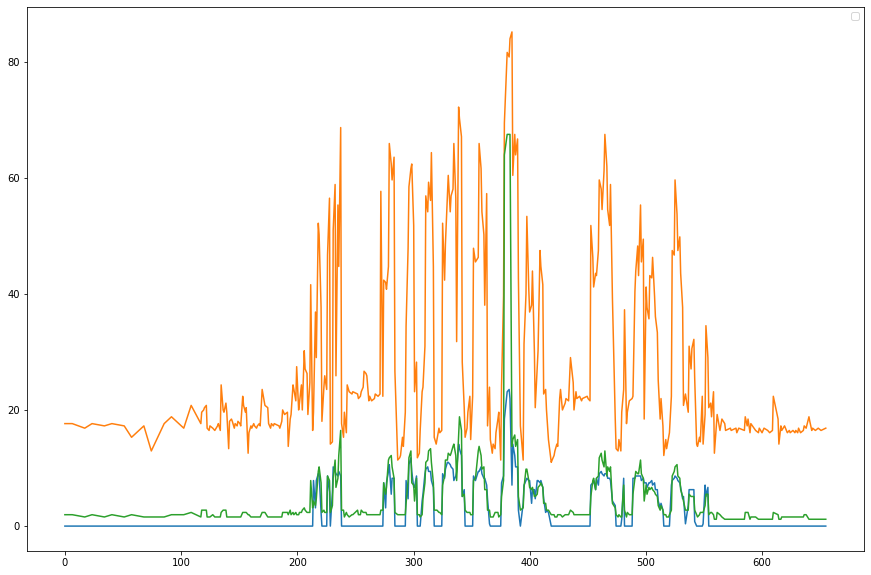

In [6]:
plt.figure(figsize=(15, 10))
#plt.plot(vehicle_times, vehicle["Speed"])
plt.plot(vehicle_times, vehicle["Relative gas pedal position"])
plt.plot(vehicle_times, vehicle["Absolute Engine Load"])
plt.plot(vehicle_times, vehicle["Relative throttle position"])
plt.legend()

In [7]:
import gpxpy

with open("gps-trace.gpx", "r") as infile:
    gpx = gpxpy.parse(infile)

track, = gpx.tracks
seg, = track.segments
gps = seg.points

In [8]:
first_pt = gps[0]
lat_to_dist = 1e3 * first_pt.distance_2d(type(first_pt)(longitude=first_pt.longitude+1e-3, latitude=first_pt.latitude))
lon_to_dist = 1e3 * first_pt.distance_2d(type(first_pt)(longitude=first_pt.longitude, latitude=first_pt.latitude+1e-3))

first_pt

GPXTrackPoint(40.1065306, -88.2494373, elevation=200.555, time=datetime.datetime(2019, 11, 1, 2, 6, 51, tzinfo=SimpleTZ("Z")), horizontal_dilution=16.08)

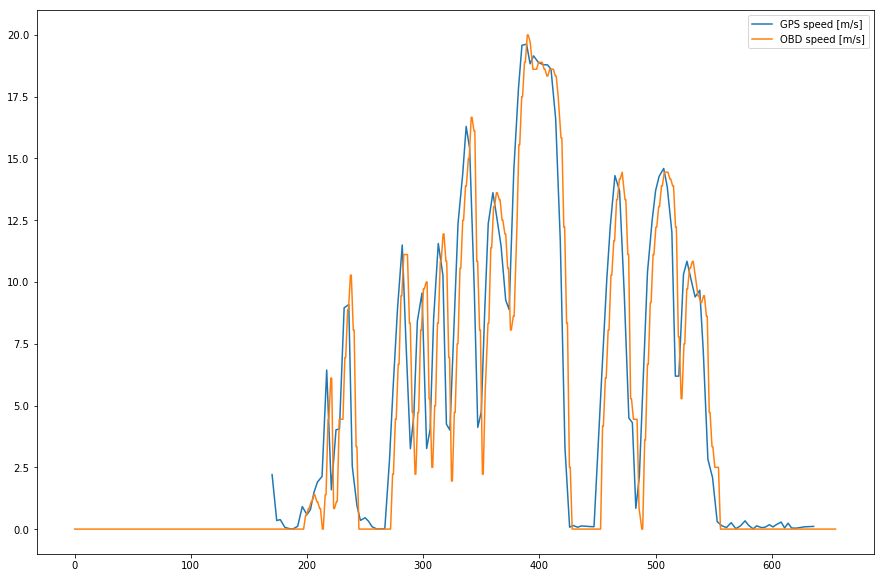

In [9]:
gps_speeds = [
    gps[i+1].distance_2d(gps[i]) / (gps[i+1].time.timestamp() - gps[i].time.timestamp())
    for i in range(len(gps)-1)
    ]

plt.figure(figsize=(15,10))
plt.plot(
    [pt.time.timestamp()-vehicle_start_time for pt in gps[:-1]],
    gps_speeds, label="GPS speed [m/s]")
plt.plot(vehicle_times,
         # convert km/h -> m/s
         vehicle["Speed"] * 1/3.6,
         label="OBD speed [m/s]")
plt.legend()

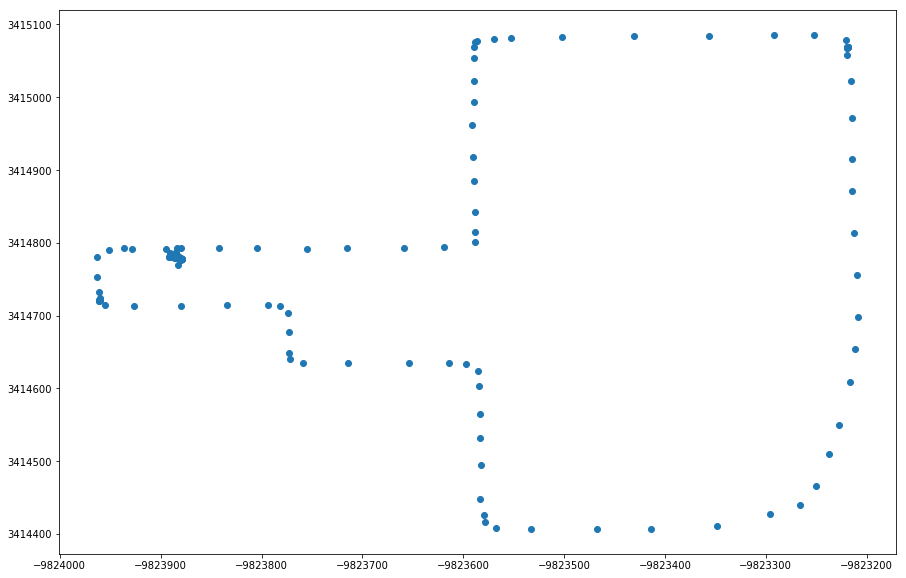

In [10]:
plt.figure(figsize=(15,10))
plt.plot(
    [lon_to_dist*pt.longitude for pt in gps],
    [lat_to_dist*pt.latitude for pt in gps],
    "o"
  )

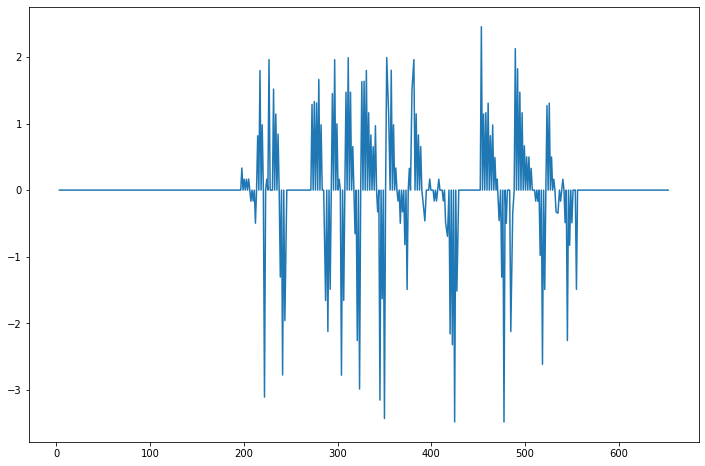

In [12]:
obd_speed = vehicle["Speed"] * 1/3.6  # m/s
obd_accelerations = []
obd_acceleration_times = []

for i in range(len(obd_speed)-1):
    obd_accelerations.append((obd_speed[i+1] - obd_speed[i])/(vehicle_times[i+1]-vehicle_times[i]))
    obd_acceleration_times.append((vehicle_times[i+1]+vehicle_times[i])/2)

plt.figure(figsize=(12, 8))
plt.plot(obd_acceleration_times, obd_accelerations)
#plt.plot(acceleration["Time (s)"], acceleration["Linear Acceleration y (m/s^2)"])

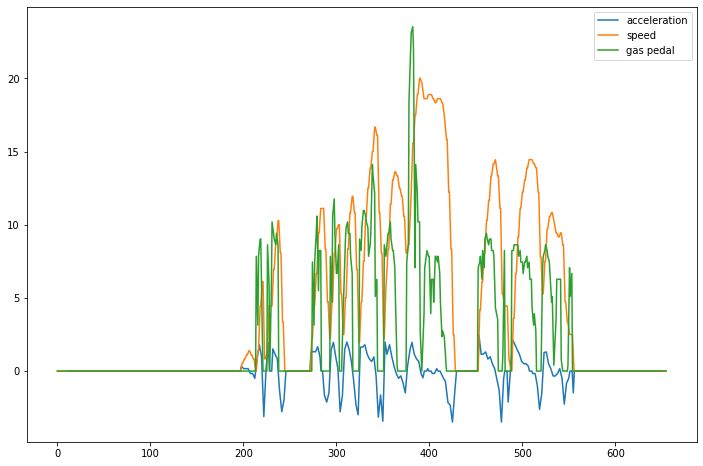

In [18]:
obd_accelerations_cleaned = []
obd_acceleration_times_cleaned = []

for i in range(1, len(obd_accelerations)-1):
    if not (abs(obd_accelerations[i]) < 0.1
            and abs(obd_accelerations[i-1]) > 0.1
            and abs(obd_accelerations[i+1]) > 0.1):
        
        obd_accelerations_cleaned.append(obd_accelerations[i])
        obd_acceleration_times_cleaned.append(obd_acceleration_times[i])
        
plt.figure(figsize=(12, 8))
plt.plot(obd_acceleration_times_cleaned, obd_accelerations_cleaned, label="acceleration")
plt.plot(vehicle_times, obd_speed, label="speed")

plt.plot(vehicle_times, vehicle["Relative gas pedal position"], label="gas pedal")
plt.legend()

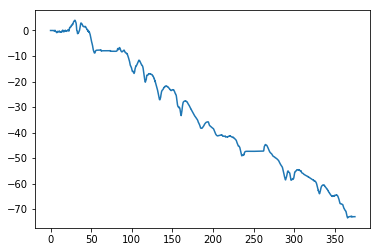

In [18]:
# integrate up acceleration to get another estimate of speed
acc_speed = 0
acc_time = acceleration["Time (s)"]
lin_acc = acceleration["Linear Acceleration y (m/s^2)"]
acc_speeds = []
for i in range(len(acceleration)-1):
    time_interval = acc_time[i+1] - acc_time[i]
    acc_speed = acc_speed + time_interval * lin_acc[i] 
    acc_speeds.append(acc_speed)

plt.plot(acc_time[:-1], acc_speeds)